In [86]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import pickle

# `Clean dataset`

In [37]:
data = pd.read_csv('sales.csv')
data.shape

(640840, 10)

In [38]:
data.head()

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882


In [39]:
data = data.drop('Unnamed: 0', axis=1)
data.shape

(640840, 9)

In [40]:
data.head()

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,366,4,2013-04-18,517,1,0,0,0,4422
1,394,6,2015-04-11,694,1,0,0,0,8297
2,807,4,2013-08-29,970,1,1,0,0,9729
3,802,2,2013-05-28,473,1,1,0,0,6513
4,726,4,2013-10-10,1068,1,1,0,0,10882


In [41]:
data.dtypes

store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday          object
school_holiday          int64
sales                   int64
dtype: object

In [42]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

data.drop('date', axis=1, inplace=True)

In [43]:
data['state_holiday'] = pd.factorize(data['state_holiday'])[0]

In [44]:
data.head()

,store_ID,day_of_week,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales,year,month,day
0,366,4,517,1,0,0,0,4422,2013,4,18
1,394,6,694,1,0,0,0,8297,2015,4,11
2,807,4,970,1,1,0,0,9729,2013,8,29
3,802,2,473,1,1,0,0,6513,2013,5,28
4,726,4,1068,1,1,0,0,10882,2013,10,10


In [45]:
data.dtypes

store_ID               int64
day_of_week            int64
nb_customers_on_day    int64
open                   int64
promotion              int64
state_holiday          int64
school_holiday         int64
sales                  int64
year                   int64
month                  int64
day                    int64
dtype: object

# `Filter dataset`

In [46]:
data_open_days = data[data['open'] == 1].copy()

data_open_days.drop('open', axis=1, inplace=True)

data_open_days.shape

(532016, 10)

In [47]:
data_without_store_ID = data.drop('store_ID', axis=1)
data_without_store_ID.shape

(640840, 10)

In [48]:
data_open_days_without_store_ID = data_open_days.drop('store_ID', axis=1)
data_open_days_without_store_ID.shape

(532016, 9)

# `Check correlations`

In [49]:
def display_heatmap(dataframe):
    corr=dataframe.corr()

    mask=np.triu(np.ones_like(corr, dtype=bool))     # generate a mask for the upper triangle

    f, ax=plt.subplots(figsize=(11, 9))                 # set up the matplotlib figure

    cmap=sns.diverging_palette(220, 10, as_cmap=True)   # generate a custom diverging colormap

    sns.heatmap(corr, mask=mask, cmap=cmap,             # draw the heatmap with the mask and correct aspect ratio
                vmax=.3, center=0, square=True,
                linewidths=.5, cbar_kws={"shrink": .5})

## `Not filtered - without store_ID`

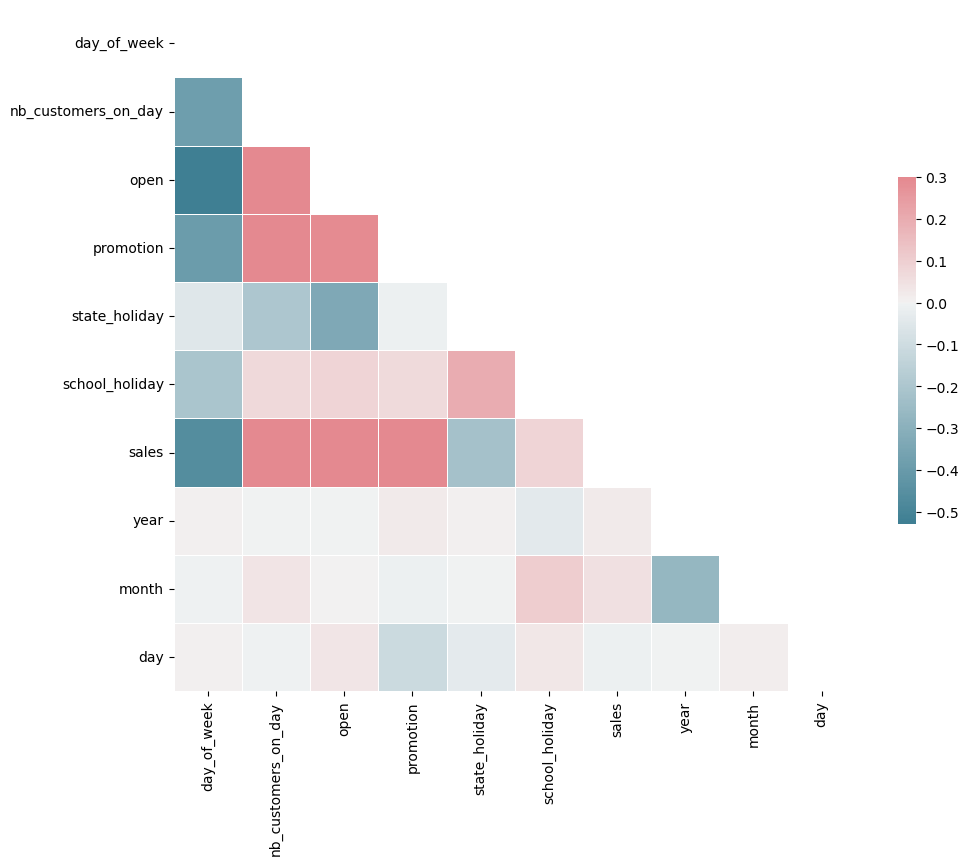

In [50]:
display_heatmap(data_without_store_ID)

## `Not filtered - with store_ID`

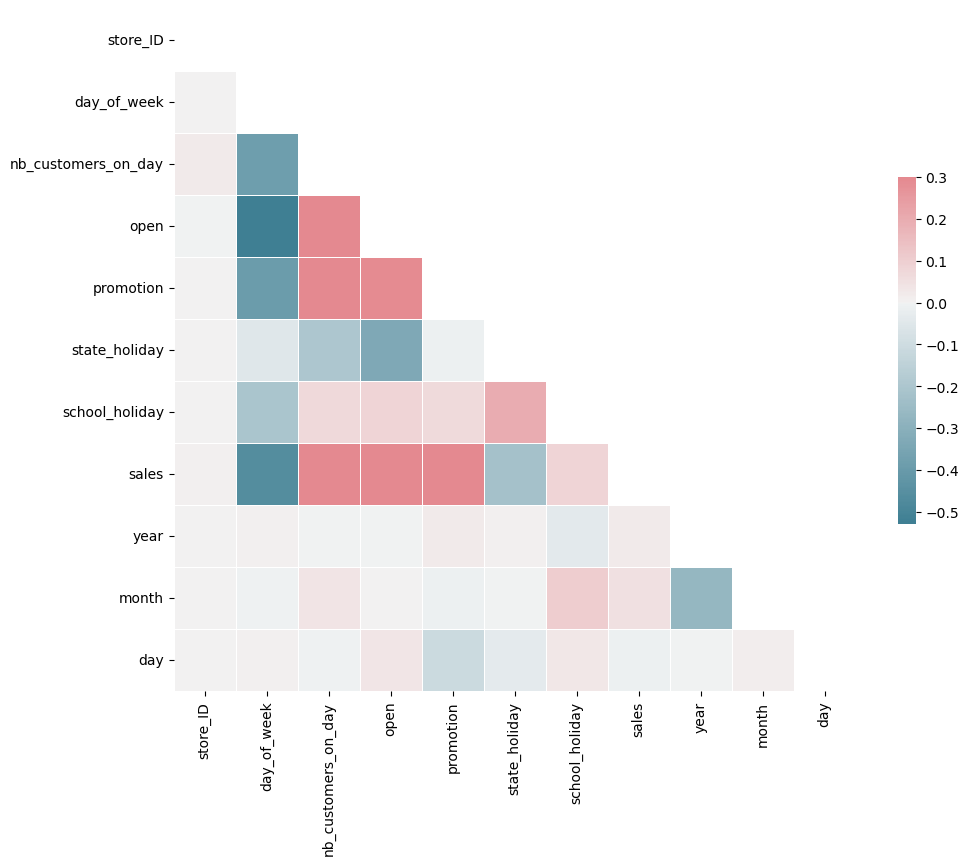

In [51]:
display_heatmap(data)

## `Filtered - without store_ID`

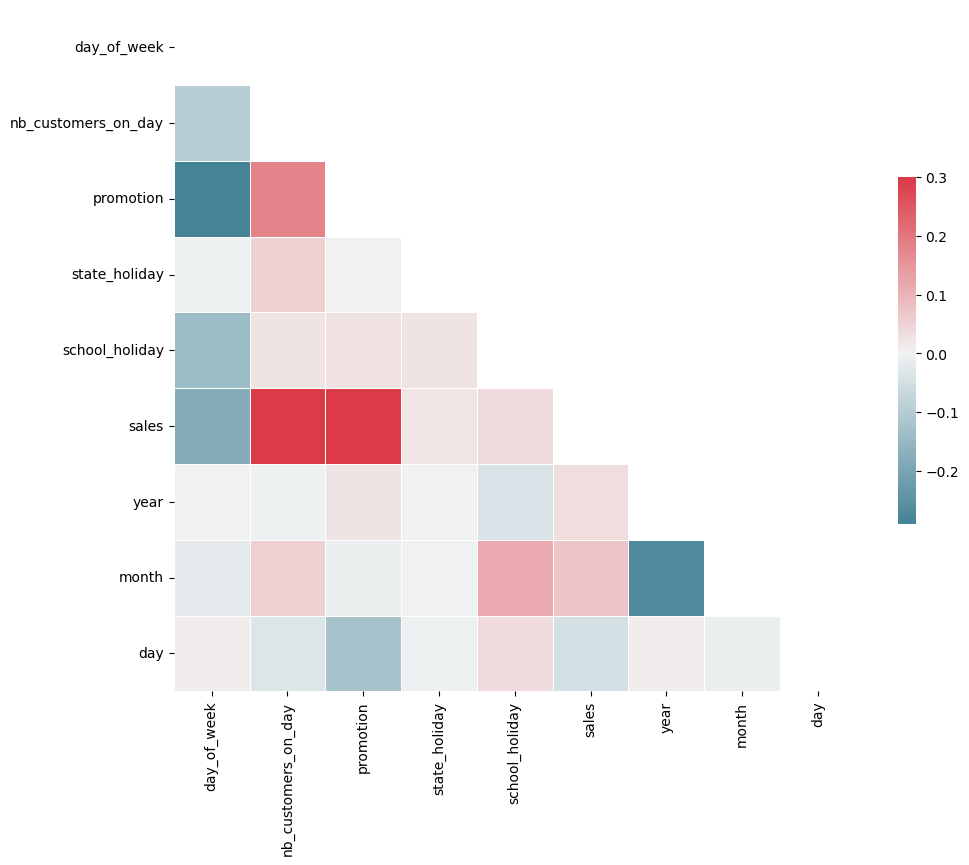

In [52]:
display_heatmap(data_open_days_without_store_ID)

## `Filtered - with store_ID`

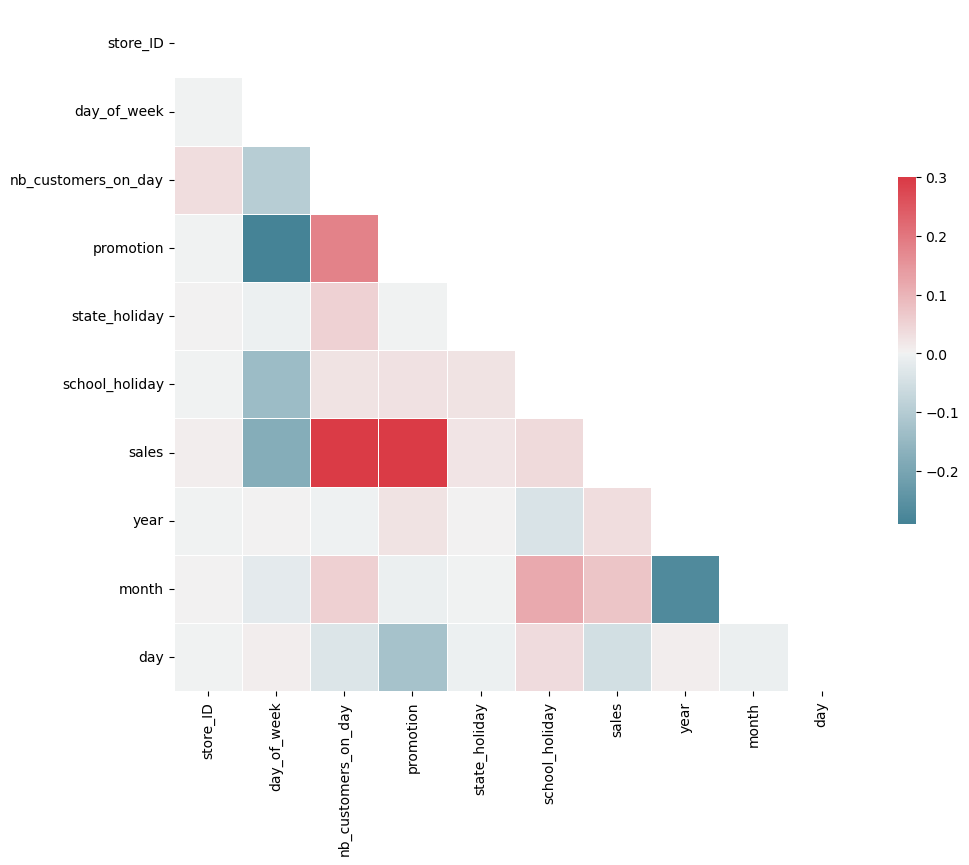

In [53]:
display_heatmap(data_open_days)

# `Test algorithms`

In [117]:
def compare_models(models, dataframe):
    fitted_models = []

    r2_list = []
    mse_list = []
    rmse_list = []
    mae_list = []

    for model in models:

        print(f"====== {model} ======")

        full_df = dataframe.sample(frac=1, random_state=10)

        y = full_df['sales']
        X = full_df.drop('sales', axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

        # Scaling data = X_train
        X_train_transformer = MinMaxScaler().fit(X_train)
        X_train_normalized = X_train_transformer.transform(X_train)
        X_train_normalized = pd.DataFrame(X_train_normalized)

        # Scaling data = X_test
        X_test_transformer = MinMaxScaler().fit(X_test)
        X_test_normalized = X_test_transformer.transform(X_test)
        X_test_normalized = pd.DataFrame(X_test_normalized)

        model.fit(X_train_normalized, y_train)

        fitted_models.append(model)

        # Make predictions on the test data
        y_pred = model.predict(X_test_normalized)

        # R2 validation
        r2 = r2_score(y_test, y_pred)
        print("R2:", r2)

        # MSE validation
        mse=mean_squared_error(y_test, y_pred)
        print("MSE:", mse)

        # RMSE validation
        rmse = np.sqrt(mse)
        print("RMSE:", rmse)

        # MAE validation
        mae=mean_absolute_error(y_test, y_pred)
        print("MAE:", mae)

        r2_list.append(r2)
        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)


    summary = {
        'Algorithm': model,
        'R2': r2_list,
        'MSE': mse_list,
        'RMSE': rmse_list,
        'MAE': mae_list
    }
    summary = pd.DataFrame(summary)
    # summary.columns = models

    return summary, fitted_models

In [55]:
models_to_test = [
    LinearRegression(n_jobs=-1),
    Lasso(random_state=10),
    Ridge(random_state=10),
    ElasticNet(random_state=10),
    XGBRegressor(),
    LGBMRegressor(n_jobs=-1, random_state=10),
    DecisionTreeRegressor()
]

models_to_test_slow = [
    KNeighborsRegressor(n_jobs=-1),
    MLPRegressor(random_state=10),
    RandomForestRegressor(n_jobs=-1, random_state=10)
]

## `Not filtered - without store_ID`

In [ ]:
data_without_store_ID_summary, data_without_store_ID_models = compare_models(models=models_to_test, dataframe=data_without_store_ID)

In [ ]:
# ====== LGBMRegressor(random_state=10) ======
# R2: 0.8717880480454334
# MSE: 1920020.1403067634
# RMSE: 1385.6479135432505
# MAE: 934.6317351470149

In [ ]:
data_without_store_ID_slow_summary, data_without_store_ID_models_slow = compare_models(models=models_to_test_slow, dataframe=data_without_store_ID)

In [ ]:
# ====== MLPRegressor(random_state=10) ======
# R2: 0.8604318711437954
# MSE: 2090082.977941105
# RMSE: 1445.711927716274
# MAE: 980.7829302460166

## `Not filtered - with store_ID`

In [ ]:
data_with_store_ID_summary, data_with_store_ID_models = compare_models(models=models_to_test, dataframe=data)

In [ ]:
# ====== XGBRegressor() ======
# R2: 0.9494461028054196
# MSE: 757062.8112657383
# RMSE: 870.0935646617198
# MAE: 628.8746932658818

In [ ]:
data_with_store_ID_slow_summary, data_with_store_ID_models_slow = compare_models(models=models_to_test_slow, dataframe=data)

In [ ]:
# ====== RandomForestRegressor(n_jobs=-1, random_state=10) ======
# R2: 0.9228395853784788
# MSE: 1155504.9888035383
# RMSE: 1074.9441793895803
# MAE: 724.3297227857188

## `Filtered - without store_ID`

In [ ]:
data_open_days_without_store_ID_summary, data_open_days_without_store_ID_models = compare_models(models=models_to_test, dataframe=data_open_days_without_store_ID)

In [ ]:
# ====== LinearRegression(n_jobs=-1) ======
# R2: 0.7115516521122665
# MSE: 2807809.682227139
# RMSE: 1675.6520170450483
# MAE: 1206.1741847849569

In [ ]:
data_open_days_without_store_ID_slow_summary, data_open_days_without_store_ID_models_slow = compare_models(models=models_to_test_slow, dataframe=data_open_days_without_store_ID)

In [ ]:
# ====== MLPRegressor(random_state=10) ======
# R2: 0.7423804028651348
# MSE: 2507716.9082911913
# RMSE: 1583.5772504968588
# MAE: 1168.3293276782179

## `Filtered - with store_ID`

In [ ]:
data_open_days_with_store_ID_summary, data_open_days_with_store_ID_models = compare_models(models=models_to_test, dataframe=data_open_days)

In [ ]:
# ====== XGBRegressor() ======
# R2: 0.9151376668371063
# MSE: 826065.6802371338
# RMSE: 908.8815545697546
# MAE: 689.5817966818616

In [68]:
data_open_days_with_store_ID_slow_summary, data_open_days_with_store_ID_models_slow = compare_models(models=models_to_test_slow, dataframe=data_open_days)

====== KNeighborsRegressor(n_jobs=-1) ======
R2: 0.7232507311395366
MSE: 2693928.678551934
RMSE: 1641.3191885041538
MAE: 1215.870440960866
====== MLPRegressor(random_state=10) ======


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


R2: 0.7447240351959148
MSE: 2484903.5567912357
RMSE: 1576.3576868183297
MAE: 1161.5617518747454
====== RandomForestRegressor(n_jobs=-1, random_state=10) ======
R2: 0.866331897098328
MSE: 1301150.0890215652
RMSE: 1140.6796610010915
MAE: 837.9384821999172


# `For now : Not filtered - with store_ID -> data_with_store_ID_models, XGBRegressor()`

# `Try find best parameters`

In [70]:
def find_best_parameters(model, param_grid, nb_cross_validations):
    grid_search_decision_tree_classifier = GridSearchCV(estimator = model, param_grid = param_grid, cv = nb_cross_validations, n_jobs=-1)

    full_df = data.sample(frac=1, random_state=10)

    y = full_df['sales']
    X = full_df.drop('sales', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

    # Scaling data = X_train
    X_train_transformer = MinMaxScaler().fit(X_train)
    X_train_normalized = X_train_transformer.transform(X_train)
    X_train_normalized = pd.DataFrame(X_train_normalized)

    grid_search_decision_tree_classifier.fit(X_train_normalized, y_train)

    print(f"Best parameters: {grid_search_decision_tree_classifier.best_params_}")
    print(f"Best score: {grid_search_decision_tree_classifier.best_score_}")

    return grid_search_decision_tree_classifier

In [71]:
grid = {
    'booster': ['gbtree', 'gblinear', 'dart', 'gbtree', 'dart'],
    'validate_parameters': [True, False]
}

In [ ]:
best_parameters_XGBRegressor_5_cv = find_best_parameters(model=XGBRegressor(), param_grid=grid, nb_cross_validations=5)

In [ ]:
best_parameters_XGBRegressor_10_cv = find_best_parameters(model=XGBRegressor(), param_grid=grid, nb_cross_validations=10)

# `Best parameters for XGBRegressor seem to be : 'booster': 'gbtree', 'validate_parameters': True`

In [ ]:
XGBRegressor_with_best_parameters_summary, XGBRegressor_with_best_parameters_models = compare_models(models=[XGBRegressor(booster='gbtree', validate_parameters=True, n_jobs=-1)], dataframe=data)

In [ ]:
# ====== XGBRegressor(base_score=None, booster='gbtree', colsample_bylevel=None,
#              colsample_bynode=None, colsample_bytree=None,
#              enable_categorical=False, gamma=None, gpu_id=None,
#              importance_type=None, interaction_constraints=None,
#              learning_rate=None, max_delta_step=None, max_depth=None,
#              min_child_weight=None, missing=nan, monotone_constraints=None,
#              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
#              predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
#              scale_pos_weight=None, subsample=None, tree_method=None,
#              validate_parameters=True, verbosity=None) ======
# /opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
#   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

# R2: 0.9494461028054196
# MSE: 757062.8112657383
# RMSE: 870.0935646617198
# MAE: 628.8746932658818

In [ ]:
XGBRegressor_default_parameters_summary, XGBRegressor_default_parameters_models = compare_models(models=[XGBRegressor(n_jobs=-1)], dataframe=data)

In [ ]:
# ====== XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
#              colsample_bynode=None, colsample_bytree=None,
#              enable_categorical=False, gamma=None, gpu_id=None,
#              importance_type=None, interaction_constraints=None,
#              learning_rate=None, max_delta_step=None, max_depth=None,
#              min_child_weight=None, missing=nan, monotone_constraints=None,
#              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
#              predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
#              scale_pos_weight=None, subsample=None, tree_method=None,
#              validate_parameters=None, verbosity=None) ======

# R2: 0.9494461028054196
# MSE: 757062.8112657383
# RMSE: 870.0935646617198
# MAE: 628.8746932658818

# `Save XGBRegressor_default_parameters_models`

In [87]:
with open(f'models/XGBRegressor_sales_model.pkl', 'wb') as f:
    pickle.dump(XGBRegressor_default_parameters_models[0], f)

# `Load XGBRegressor_default_parameters_models`

In [88]:
with open(f'models/XGBRegressor_sales_model.pkl', "rb") as f:
    sales_model = pickle.load(f)

In [95]:
data['day_of_week'].unique()

array([4, 6, 2, 7, 3, 5, 1])

# `Try fit model for each day_of_week separately`

In [144]:
unique_day_of_week = data['day_of_week'].unique()

# Split dataframe into dataframes per day_of_week
filtered_df_list = [
    {
        'day_of_week': day_of_week, 
        'dataframe': data[data['day_of_week'] == day_of_week].drop('day_of_week', axis=1)
    }
                                                  for day_of_week in unique_day_of_week
]

models_per_day_of_week_results = [
    {
        'day_of_week': obj['day_of_week'],
        'summary_and_fitted_model': compare_models(models=[XGBRegressor(n_jobs=-1)], dataframe=obj['dataframe'])
    }
    for obj in filtered_df_list
]

====== XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) ======


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


R2: 0.9501692890490572
MSE: 519540.2217144895
RMSE: 720.7913857105185
MAE: 536.4750056057629
====== XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) ======


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


R2: 0.9112405279577225
MSE: 746686.3910660364
RMSE: 864.1101729907109
MAE: 679.4196831329702
====== XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) ======


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


R2: 0.9116955202801547
MSE: 840643.8835423354
RMSE: 916.8663389733181
MAE: 698.6685287363982
====== XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) ======


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


R2: 0.9954556959261214
MSE: 12768.023143889466
RMSE: 112.99567754515863
MAE: 12.142054875814203
====== XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) ======


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


R2: 0.9288333456689236
MSE: 605265.6833317351
RMSE: 777.9882282732401
MAE: 578.1058013729056
====== XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) ======


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


R2: 0.9262805127020661
MSE: 718277.552113349
RMSE: 847.5125675253134
MAE: 643.5809295206052
====== XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) ======


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


R2: 0.9389285463338202
MSE: 960774.9055412391
RMSE: 980.1912596739675
MAE: 698.4652847029017


In [154]:
models_per_day_of_week_summaries = [result['summary_and_fitted_model'][0].drop('Algorithm', axis=1).assign(day_of_week = result['day_of_week']) for result in models_per_day_of_week_results]

models_per_day_of_week_comparison = pd.concat(models_per_day_of_week_summaries, axis=0)
models_per_day_of_week_comparison

,R2,MSE,RMSE,MAE,day_of_week
0,0.950169,519540.221714,720.791386,536.475006,4
0,0.911241,746686.391066,864.110173,679.419683,6
0,0.911696,840643.883542,916.866339,698.668529,2
0,0.995456,12768.023144,112.995678,12.142055,7
0,0.928833,605265.683332,777.988228,578.105801,3
0,0.926281,718277.552113,847.512568,643.580930,5
0,0.938929,960774.905541,980.191260,698.465285,1


# `Save models per day_of_week`

In [152]:
def save_model(result):
    with open(f"models/XGBRegressor_sales_model_day{result['day_of_week']}.pkl", 'wb') as f:
        pickle.dump(result['summary_and_fitted_model'][1], f)

[save_model(result) for result in models_per_day_of_week_results]

[None, None, None, None, None, None, None]

# `Load models per day_of_week`

In [163]:
with open(f'models/XGBRegressor_sales_model_day1.pkl', "rb") as f:
    XGBRegressor_sales_model_day1_model = pickle.load(f)

with open(f'models/XGBRegressor_sales_model_day2.pkl', "rb") as f:
    XGBRegressor_sales_model_day2_model = pickle.load(f)

with open(f'models/XGBRegressor_sales_model_day3.pkl', "rb") as f:
    XGBRegressor_sales_model_day3_model = pickle.load(f)

with open(f'models/XGBRegressor_sales_model_day4.pkl', "rb") as f:
    XGBRegressor_sales_model_day4_model = pickle.load(f)

with open(f'models/XGBRegressor_sales_model_day5.pkl', "rb") as f:
    XGBRegressor_sales_model_day5_model = pickle.load(f)

with open(f'models/XGBRegressor_sales_model_day6.pkl', "rb") as f:
    XGBRegressor_sales_model_day6_model = pickle.load(f)

with open(f'models/XGBRegressor_sales_model_day7.pkl', "rb") as f:
    XGBRegressor_sales_model_day7_model = pickle.load(f)

# `Predict sales`

In [155]:
validation_data = pd.read_csv('validation_for_students.csv')
validation_data.shape

(71205, 9)

In [156]:
validation_data.head()

,True_index,Store_ID,Day_of_week,Date,Nb_customers_on_day,Open,Promotion,State_holiday,School_holiday
0,7,764,4,2013-12-26,0,0,0,c,1
1,19,22,3,2013-05-22,449,1,0,0,1
2,31,1087,6,2013-06-29,622,1,0,0,0
3,45,139,6,2013-08-17,314,1,0,0,0
4,56,568,1,2014-04-07,356,1,0,0,0


In [158]:
validation_data.columns = validation_data.columns.str.lower()

In [159]:
validation_data.head()

,true_index,store_id,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday
0,7,764,4,2013-12-26,0,0,0,c,1
1,19,22,3,2013-05-22,449,1,0,0,1
2,31,1087,6,2013-06-29,622,1,0,0,0
3,45,139,6,2013-08-17,314,1,0,0,0
4,56,568,1,2014-04-07,356,1,0,0,0


In [160]:
validation_data['date'] = pd.to_datetime(validation_data['date'])
validation_data['year'] = validation_data['date'].dt.year
validation_data['month'] = validation_data['date'].dt.month
validation_data['day'] = validation_data['date'].dt.day

validation_data.drop('date', axis=1, inplace=True)

In [161]:
validation_data['state_holiday'] = pd.factorize(validation_data['state_holiday'])[0]

In [162]:
validation_data.head()

,true_index,store_id,day_of_week,nb_customers_on_day,open,promotion,state_holiday,school_holiday,year,month,day
0,7,764,4,0,0,0,0,1,2013,12,26
1,19,22,3,449,1,0,1,1,2013,5,22
2,31,1087,6,622,1,0,1,0,2013,6,29
3,45,139,6,314,1,0,1,0,2013,8,17
4,56,568,1,356,1,0,1,0,2014,4,7


In [186]:
validation_data.shape

(71205, 11)

In [252]:
# unique_day_of_week = validation_data['day_of_week'].unique()
unique_day_of_week_validation_data = sorted(validation_data['day_of_week'].unique())
models_day_of_week_validation_data = [
    XGBRegressor_sales_model_day1_model,
    XGBRegressor_sales_model_day2_model,
    XGBRegressor_sales_model_day3_model,
    XGBRegressor_sales_model_day4_model,
    XGBRegressor_sales_model_day5_model,
    XGBRegressor_sales_model_day6_model,
    XGBRegressor_sales_model_day7_model
]

def create_prediction_df(day_of_week, model):
    filtered_df = validation_data[validation_data['day_of_week'] == day_of_week]
    predictions = model.predict(filtered_df.drop(['true_index', 'day_of_week'], axis=1))
    df = pd.concat([filtered_df[['true_index']].reset_index(), pd.DataFrame(predictions, columns=['sales'])], axis=1)

    return df[['true_index', 'sales']]

predictions_df_list = [create_prediction_df(day_of_week, models[0]) for day_of_week, models in zip(unique_day_of_week_validation_data, models_day_of_week_validation_data)]

predicted_data = pd.concat(predictions_df_list, axis=0)

In [253]:
predicted_data.to_csv('predicted_data.csv')